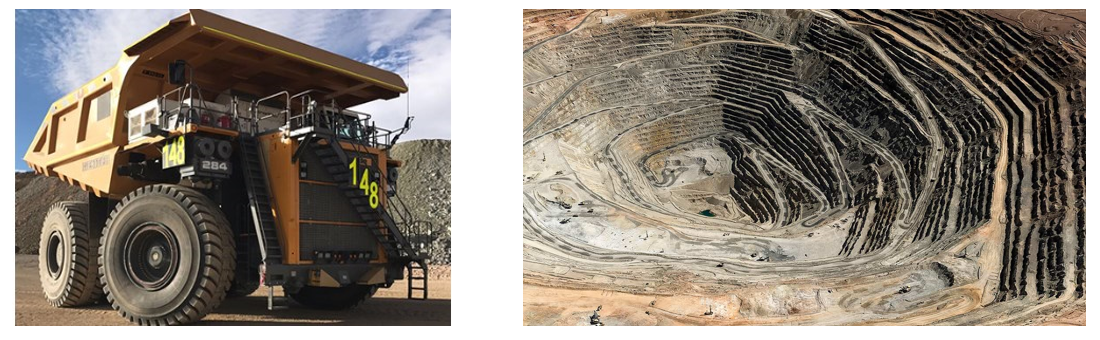

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
df = pd.read_parquet("dataDumper.parquet")

In [39]:
len(df.columns)

33

In [40]:
df.columns

Index(['Time_utc', 'VehicleName', 'VehicleType', 'Pressure_Pa_1',
       'Pressure_Pa_2', 'Pressure_Pa_3', 'Pressure_Pa_4', 'Pressure_Pa_5',
       'Pressure_Pa_6', 'Temperature_K_1', 'Temperature_K_2',
       'Temperature_K_3', 'Temperature_K_4', 'Temperature_K_5',
       'Temperature_K_6', 'ColdPressure_Pa_1', 'ColdPressure_Pa_2',
       'ColdPressure_Pa_3', 'ColdPressure_Pa_4', 'ColdPressure_Pa_5',
       'ColdPressure_Pa_6', 'Latitude_dd', 'Longitude_dd', 'Altitude_m',
       'Speed_mps', 'epsilonX', 'epsilonY', 'epsilonZ', 'epsilonSpeed',
       'AtmosphericPressure_Pa', 'dt_s', 'dd_m', 'RatioPayload'],
      dtype='object')

In [41]:
df["VehicleName"].unique() # only 1 vehicle

array(['C-132'], dtype=object)

# Feature addition

In [42]:
import numpy as np
from scipy import stats

# Create a copy for feature engineering
df_features = df.copy()

## 1. Tire Pressure Features

In [43]:
# Tire pressure statistics across all 6 tires
pressure_cols = [f'Pressure_Pa_{i}' for i in range(1, 7)]

df_features['pressure_mean'] = df_features[pressure_cols].mean(axis=1)
df_features['pressure_std'] = df_features[pressure_cols].std(axis=1)
df_features['pressure_min'] = df_features[pressure_cols].min(axis=1)
df_features['pressure_max'] = df_features[pressure_cols].max(axis=1)
df_features['pressure_range'] = df_features['pressure_max'] - df_features['pressure_min']

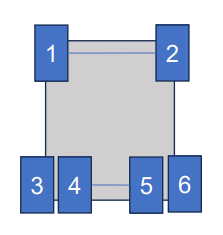

In [44]:
# Pressure imbalance (asymmetry between left and right)
df_features['pressure_left_right_diff'] = (
    (df_features['Pressure_Pa_1'] + df_features['Pressure_Pa_3'] + df_features['Pressure_Pa_4']) / 3 -
    (df_features['Pressure_Pa_2'] + df_features['Pressure_Pa_5'] + df_features['Pressure_Pa_6']) / 3
)

# Pressure rate of change (derivative)
df_features['pressure_mean_diff'] = df_features['pressure_mean'].diff()
df_features['pressure_mean_diff_rate'] = df_features['pressure_mean_diff'] / df_features['dt_s']

print("Tire pressure features created:")
print(df_features[['pressure_mean', 'pressure_std', 'pressure_range', 'pressure_left_right_diff']].head())

Tire pressure features created:
   pressure_mean  pressure_std  pressure_range  pressure_left_right_diff
0  889333.333333  88032.235277   205989.066667             -13989.066667
1  889333.333333  88050.326882   205822.066671             -13822.066671
2  889333.333333  88068.479428   205655.633331             -13655.633331
3  889333.333333  88086.757689   205489.166669             -13489.166669
4  889333.333333  88105.634883   205318.400000             -13318.400000


In [45]:
df_features['pressure_left_right_diff'].min(), df_features['pressure_left_right_diff'].max(), df_features['pressure_left_right_diff'].mean()

(-302647.54444515554, 209666.66666666674, -776.335699930796)

## 2. Temperature Features

In [46]:
# Temperature statistics across all 6 tires
temp_cols = [f'Temperature_K_{i}' for i in range(1, 7)]

df_features['temp_mean'] = df_features[temp_cols].mean(axis=1)
df_features['temp_std'] = df_features[temp_cols].std(axis=1)
df_features['temp_min'] = df_features[temp_cols].min(axis=1)
df_features['temp_max'] = df_features[temp_cols].max(axis=1)
df_features['temp_range'] = df_features['temp_max'] - df_features['temp_min']

In [47]:
# Temperature increase from cold pressure
cold_pressure_cols = [f'ColdPressure_Pa_{i}' for i in range(1, 7)]
df_features['temp_increase'] = df_features['temp_mean'] - df_features[cold_pressure_cols].mean(axis=1)

# Temperature rate of change
df_features['temp_mean_diff'] = df_features['temp_mean'].diff()
df_features['temp_mean_diff_rate'] = df_features['temp_mean_diff'] / df_features['dt_s']

print("Temperature features created:")
print(df_features[['temp_mean', 'temp_std', 'temp_range']].head())

Temperature features created:
    temp_mean  temp_std  temp_range
0  341.649089  2.880783         9.0
1  341.635172  2.878112         9.0
2  341.621303  2.875848         9.0
3  341.607431  2.873985         9.0
4  341.593200  2.872490         9.0


## 3. Motion and Trajectory Features

In [48]:
# Acceleration features
df_features['acceleration'] = df_features['Speed_mps'].diff() / df_features['dt_s']
df_features['acceleration_abs'] = df_features['acceleration'].abs()

# Jerk (rate of change of acceleration)
df_features['jerk'] = df_features['acceleration'].diff() / df_features['dt_s']

# Speed statistics (rolling windows)
df_features['speed_rolling_mean_10'] = df_features['Speed_mps'].rolling(window=10, min_periods=1).mean()
df_features['speed_rolling_std_10'] = df_features['Speed_mps'].rolling(window=10, min_periods=1).std()
df_features['speed_rolling_max_10'] = df_features['Speed_mps'].rolling(window=10, min_periods=1).max()

# Heading/bearing calculation (direction of movement) (0 to 360 degrees)
df_features['lat_diff'] = df_features['Latitude_dd'].diff()
df_features['lon_diff'] = df_features['Longitude_dd'].diff()
# heading in degrees 0..360 (0 = north)
df_features['heading'] = (np.degrees(np.arctan2(df_features['lon_diff'], df_features['lat_diff'])) + 360) % 360


# Heading change rate (turning indicators)
# Calculate raw heading difference and wrap angular difference to [-180, 180]
heading_diff_raw = df_features['heading'].diff()
df_features['heading_change'] = (heading_diff_raw + 180) % 360 - 180
df_features['heading_change_abs'] = df_features['heading_change'].abs()

# Curvature (indicates sharp turns)
df_features['curvature'] = df_features['heading_change'] / df_features['dd_m'].replace(0, np.nan)

print("Motion features created:")
print(df_features[['acceleration', 'jerk', 'heading', 'curvature']].describe())

Motion features created:
        acceleration           jerk        heading      curvature
count  201311.000000  201310.000000  201311.000000  104272.000000
mean        0.000268       0.000043     104.261556       0.164742
std         0.147177       0.033320     123.826098      23.871109
min        -1.860559      -0.396492       0.000000    -993.977278
25%        -0.010218      -0.002420       0.000000      -0.122338
50%         0.000000       0.000000      32.074220       0.011799
75%         0.020400       0.004108     215.973953       0.155218
max         1.224155       0.471191     359.802508     968.548300


In [49]:
# filter coords for curvature sup to th
th = 180  # curvature threshold
df_curvature = df_features[df_features['curvature'].abs() > th] # curvature is in degrees per meter

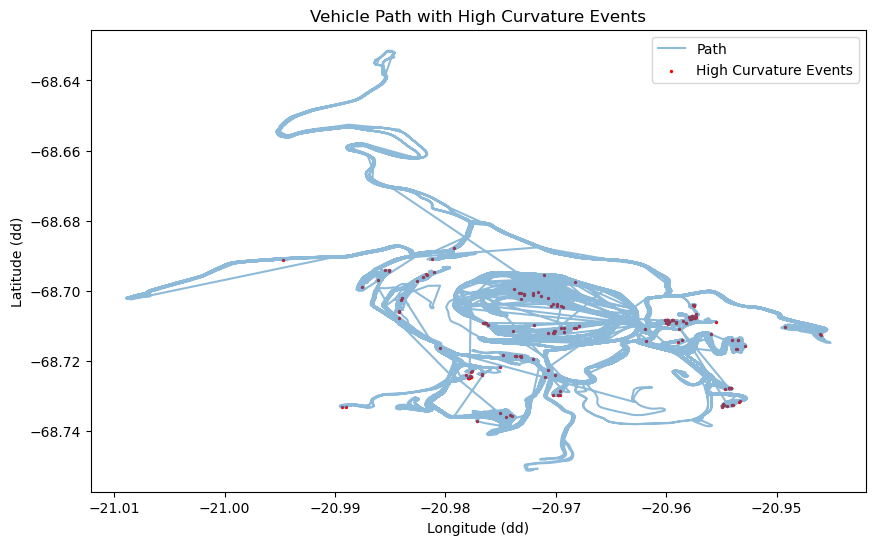

In [50]:
# plot high curvature events
plt.figure(figsize=(10, 6))
plt.plot(df_features['Latitude_dd'], df_features['Longitude_dd'], label='Path', alpha=0.5)
plt.scatter(df_curvature['Latitude_dd'], df_curvature['Longitude_dd'], color='red', label='High Curvature Events', s=2)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.title('Vehicle Path with High Curvature Events')
plt.legend()
plt.show()

## 4. Time-based Features

In [51]:
df_features['Time_utc'] = df_features['Time_utc'].str.replace(r'\.\d+', '', regex=True) # remove milliseconds
df_features['Time_datetime'] = pd.to_datetime(df_features['Time_utc']) # Convert Time_utc to datetime format


In [52]:
# Time since start
df_features['time_since_start'] = (df_features['Time_datetime'] - df_features['Time_datetime'].iloc[0]).dt.total_seconds()

# Cumulative distance
df_features['cumulative_distance'] = df_features['dd_m'].cumsum()

## 5. Environmental Features

In [53]:
# Altitude features
df_features['altitude_diff'] = df_features['Altitude_m'].diff()
df_features['altitude_rate'] = df_features['altitude_diff'] / df_features['dt_s']  # vertical speed
df_features['altitude_rolling_std'] = df_features['Altitude_m'].rolling(window=10, min_periods=1).std()

# Grade/slope (rise over run)
df_features['grade'] = df_features['altitude_diff'] / df_features['dd_m'].replace(0, np.nan)
df_features['grade_abs'] = df_features['grade'].abs()

# Atmospheric pressure change
df_features['atm_pressure_diff'] = df_features['AtmosphericPressure_Pa'].diff()

print("Environmental features created:")
print(df_features[['altitude_rate', 'grade', 'atm_pressure_diff']].describe())

Environmental features created:
       altitude_rate          grade  atm_pressure_diff
count  201311.000000  104273.000000      200318.000000
mean        0.002248       0.017251          -0.117632
std         0.338623       0.197182          26.222493
min       -32.754405     -20.548161       -3547.365983
25%         0.000000      -0.030638          -4.742413
50%         0.000000       0.013145          -0.274117
75%         0.100020       0.078357           1.536986
max         6.888158      25.488996        2735.394809


## 6. Feature Summary and Export

In [54]:
# Display all new features created
new_features = [col for col in df_features.columns if col not in df.columns]
print(f"Total new features created: {len(new_features)}\n")
print("New features list:")
for i, feature in enumerate(new_features, 1):
    print(f"{i}. {feature}")

Total new features created: 37

New features list:
1. pressure_mean
2. pressure_std
3. pressure_min
4. pressure_max
5. pressure_range
6. pressure_left_right_diff
7. pressure_mean_diff
8. pressure_mean_diff_rate
9. temp_mean
10. temp_std
11. temp_min
12. temp_max
13. temp_range
14. temp_increase
15. temp_mean_diff
16. temp_mean_diff_rate
17. acceleration
18. acceleration_abs
19. jerk
20. speed_rolling_mean_10
21. speed_rolling_std_10
22. speed_rolling_max_10
23. lat_diff
24. lon_diff
25. heading
26. heading_change
27. heading_change_abs
28. curvature
29. Time_datetime
30. time_since_start
31. cumulative_distance
32. altitude_diff
33. altitude_rate
34. altitude_rolling_std
35. grade
36. grade_abs
37. atm_pressure_diff


In [55]:
# Check for any infinite or NaN values in the new features
print("Checking for data quality issues:\n")
print(f"Total NaN values: {df_features[new_features].isna().sum().sum()}")
print(f"Total infinite values: {np.isinf(df_features[new_features].select_dtypes(include=[np.number])).sum().sum()}")

# Show features with most NaN values
nan_counts = df_features[new_features].isna().sum().sort_values(ascending=False)
print("\nTop features with NaN values:")
print(nan_counts[nan_counts > 0].head(10))

Checking for data quality issues:

Total NaN values: 299778
Total infinite values: 0

Top features with NaN values:
curvature                   97040
grade_abs                   97039
grade                       97039
pressure_left_right_diff     3202
cumulative_distance          2634
atm_pressure_diff             994
pressure_mean_diff            134
pressure_mean_diff_rate       134
temp_mean_diff_rate           134
temp_mean_diff                134
dtype: int64


In [56]:
# Export the feature-enhanced dataset
df_features.to_parquet('dataDumper_with_features.parquet', index=False)

print("Feature datasets saved:")
print("- dataDumper_with_features.parquet (time-series data with all features)")

Feature datasets saved:
- dataDumper_with_features.parquet (time-series data with all features)
